# Setup and Configuration

In [1]:
# Import libraries
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Set fixed seeds for complete reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Data Loading and Preparation

In [ ]:
def load_data():
    # Load training and test data
    X_train = pd.read_csv('UCI_HAR_Dataset/train/X_train.txt', sep='\\s+', header=None)
    y_train = pd.read_csv('UCI_HAR_Dataset/train/y_train.txt', sep='\\s+', header=None, names=['Activity'])
    X_test = pd.read_csv('UCI_HAR_Dataset/test/X_test.txt', sep='\\s+', header=None)
    y_test = pd.read_csv('UCI_HAR_Dataset/test/y_test.txt', sep='\\s+', header=None, names=['Activity'])

    # Load feature names
    features = pd.read_csv('UCI_HAR_Dataset/features.txt', sep='\\s+', header=None)
    feature_names = features[1].tolist()  # Take the names from the second column

    X_train.columns = feature_names
    X_test.columns = feature_names

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data()

# Activity labels mapping
activity_labels = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

# Map activity codes to labels
y_train['Activity'] = y_train['Activity'].map(activity_labels)
y_test['Activity'] = y_test['Activity'].map(activity_labels)

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

# Data Preprocessing

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Encode activity labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train['Activity'])
y_val_encoded = encoder.transform(y_val['Activity'])
y_test_encoded = encoder.transform(y_test['Activity'])

# Store label mapping for later use
activity_labels = dict(enumerate(encoder.classes_))
print("Activity label mapping:", activity_labels)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train_encoded).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.LongTensor(y_val_encoded).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test_encoded).to(device)

# Create DataLoader objects
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Activity label mapping: {0: 'LAYING', 1: 'SITTING', 2: 'STANDING', 3: 'WALKING', 4: 'WALKING_DOWNSTAIRS', 5: 'WALKING_UPSTAIRS'}


# Model Architecture

In [5]:
class HAR_MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HAR_MLP, self).__init__()
        # Layer 1: input_size -> 128
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128) 
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.19)
        
        # Layer 2: 128 -> 128
        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)  
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.14)  
        
        # Output layer: 64 -> num_classes
        self.fc_out = nn.Linear(128, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        out = self.fc_out(out)
        return out

# Training Configuration

In [6]:
# Initialize model
input_size = X_train.shape[1]
num_classes = len(np.unique(y_train_encoded))
model = HAR_MLP(input_size, num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=2e-4,           
    weight_decay=2e-7
)

# Training parameters
num_epochs = 200
best_val_loss = float('inf')
patience = 10
no_improve = 0

# Track loss values
train_losses = []
val_losses = []

# Training Loop

In [7]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate epoch metrics
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_acc = 100 * correct / total
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader) 
        val_losses.append(avg_val_loss)
        val_acc = 100 * correct / total

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.2f}%')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)

Epoch [1/200]
Train Loss: 0.8047, Accuracy: 76.59%
Val Loss: 0.3320, Val Acc: 94.22%
--------------------------------------------------
Epoch [2/200]
Train Loss: 0.2938, Accuracy: 92.99%
Val Loss: 0.1690, Val Acc: 96.13%
--------------------------------------------------
Epoch [3/200]
Train Loss: 0.1875, Accuracy: 95.27%
Val Loss: 0.1126, Val Acc: 96.87%
--------------------------------------------------
Epoch [4/200]
Train Loss: 0.1406, Accuracy: 96.24%
Val Loss: 0.0832, Val Acc: 97.62%
--------------------------------------------------
Epoch [5/200]
Train Loss: 0.1156, Accuracy: 96.72%
Val Loss: 0.0785, Val Acc: 97.48%
--------------------------------------------------
Epoch [6/200]
Train Loss: 0.0970, Accuracy: 97.33%
Val Loss: 0.0750, Val Acc: 97.69%
--------------------------------------------------
Epoch [7/200]
Train Loss: 0.0840, Accuracy: 97.62%
Val Loss: 0.0645, Val Acc: 97.82%
--------------------------------------------------
Epoch [8/200]
Train Loss: 0.0740, Accuracy: 97.7

# Evaluation

Final Test Accuracy: 95.79%


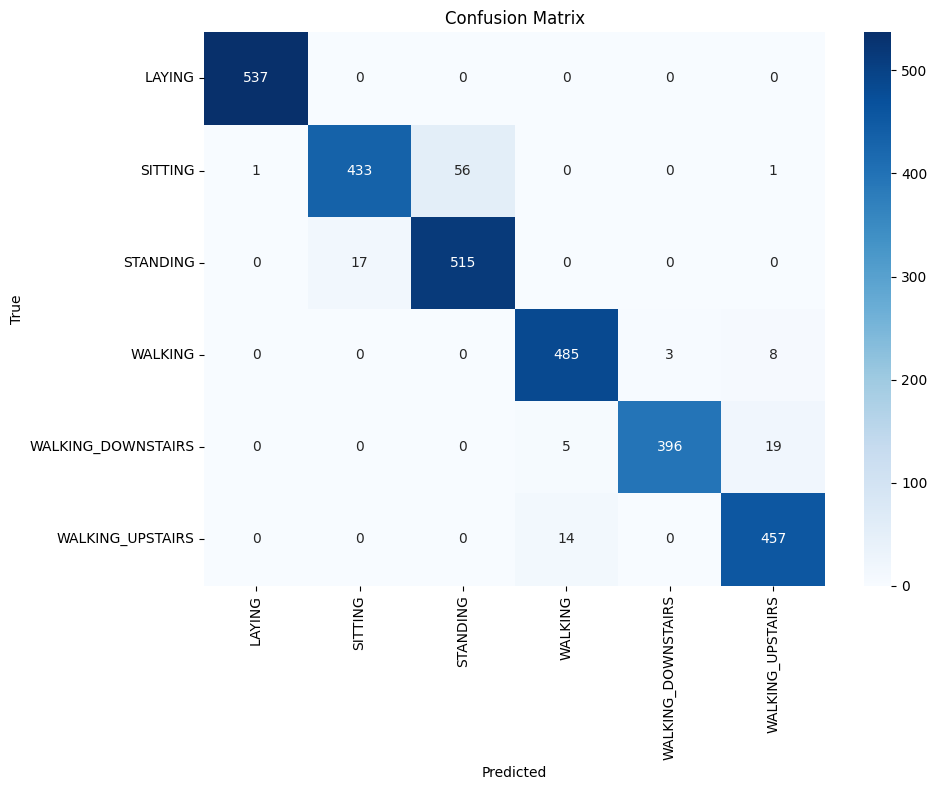


Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.88      0.92       491
          STANDING       0.90      0.97      0.93       532
           WALKING       0.96      0.98      0.97       496
WALKING_DOWNSTAIRS       0.99      0.94      0.97       420
  WALKING_UPSTAIRS       0.94      0.97      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



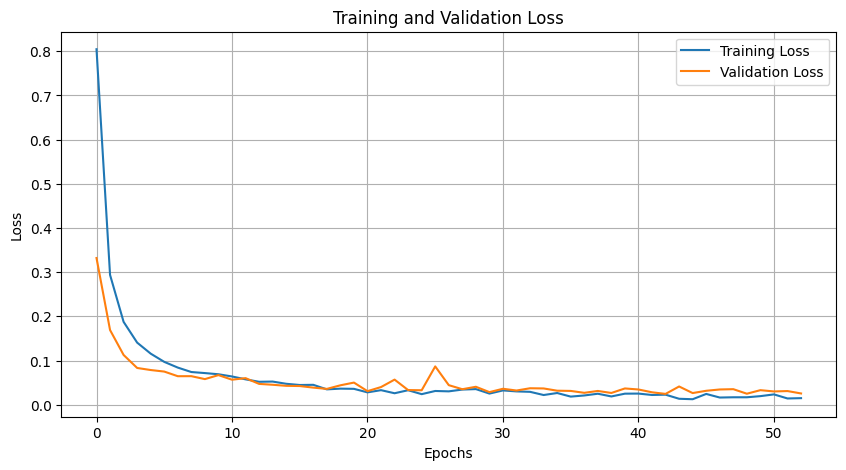

In [8]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Test evaluation
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    print(f'Final Test Accuracy: {test_acc:.2f}%')


# Confusion matrix
y_pred = np.array(all_preds)
y_true = np.array(all_targets)
class_names = list(activity_labels.values())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()